<a href="https://colab.research.google.com/github/Kirui-Brian/Biometrics_Systems_Security/blob/main/03_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face** Recognition


---

Simple implementation of face recognition leveraging [ArcFace](https://openaccess.thecvf.com/content_CVPR_2019/papers/Deng_ArcFace_Additive_Angular_Margin_Loss_for_Deep_Face_Recognition_CVPR_2019_paper.pdf).  

Language: Python 3  

Needed libraries:
* NumPy (https://numpy.org/)
* matplotlib (https://matplotlib.org/)
* OpenCV (https://opencv.org/)
* ArcFace implementation (https://github.com/mobilesec/arcface-tensorflowlite), installed through PyPI (https://pypi.org/project/pip/).


## Needed libraries and files

In [53]:
# download of pre-trained face detection models
!pip install gdown
!gdown 1SLPTyomKCNF7j98Vf0L00fWZy_uiKsHn
!gdown 1r22yYX5sqor0vgqXoJcfdRkApji8w-7G
!gdown 1vXBmymfKmJp1B8hjyjxJKUWfK686ptXX

Downloading...
From (original): https://drive.google.com/uc?id=1SLPTyomKCNF7j98Vf0L00fWZy_uiKsHn
From (redirected): https://drive.google.com/uc?id=1SLPTyomKCNF7j98Vf0L00fWZy_uiKsHn&confirm=t&uuid=f3afb1a2-2921-4e60-ba62-b7bb77035a87
To: /content/violajones_haarcascade_eye.xml
100% 341k/341k [00:00<00:00, 105MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1r22yYX5sqor0vgqXoJcfdRkApji8w-7G
From (redirected): https://drive.google.com/uc?id=1r22yYX5sqor0vgqXoJcfdRkApji8w-7G&confirm=t&uuid=80f3af42-3d04-4738-87f4-9376319eb741
To: /content/violajones_haarcascade_frontalface_default.xml
100% 930k/930k [00:00<00:00, 133MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1vXBmymfKmJp1B8hjyjxJKUWfK686ptXX
From (redirected): https://drive.google.com/uc?id=1vXBmymfKmJp1B8hjyjxJKUWfK686ptXX&confirm=t&uuid=02b7f793-98f1-45cc-b23e-88d4052547f3
To: /content/model.tflite
100% 161M/161M [00:01<00:00, 111MB/s]


In [54]:
# ArcFace instalation and auxiliary libraries
# Reference: https://github.com/mobilesec/arcface-tensorflowlite
!pip install arcface

In [55]:
# other imported libraries
import numpy as np
print('NumPy version', np.__version__)

import matplotlib as plt
print('Matplotlib version', plt.__version__)

import cv2
print('OpenCV version', cv2.__version__)

NumPy version 2.0.2
Matplotlib version 3.10.0
OpenCV version 4.13.0


-------------------
## Face acquisition

### Auxiliary function
* <code>_capture_png</code>: to open the webcam and capture a PNG file.


In [83]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# javascript-based function to capture pictures from the webcam in PNG
def _capture_png(filename):
  js = Javascript('''
    async function capture() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture PNG';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();

      return canvas.toDataURL('image/png');
    }
    ''')

  display(js)
  data = eval_js('capture()')
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

<IPython.core.display.Javascript object>

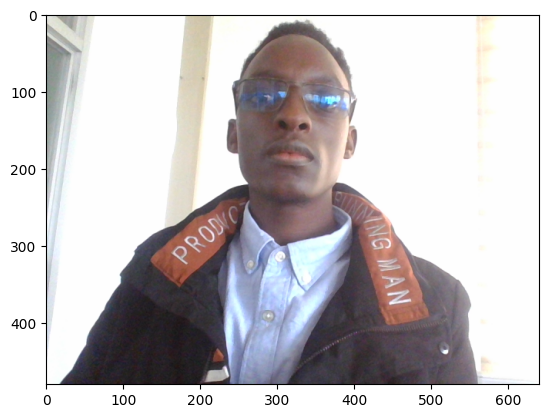

In [120]:
# tests capturing PNG file from the webcam
# webcam test
image_filepath = '/content/capture.png'
_capture_png(image_filepath)

image = cv2.imread(image_filepath)
plt.pyplot.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.pyplot.show()

### Main functions

In [121]:
# Acquires an image that might contain a face from the given file path.
# The image is acquired with three color channels (BGR).
# Parameters
# file_path: The path to the image file containing the face.
# view: TRUE if loaded image must be shown, FALSE otherwise.
def acquire_from_file(file_path, view=False):
    # reads the image from the given file path
    # and returns it
    image = cv2.imread(file_path, cv2.IMREAD_COLOR)

    # shows the read image, if it is the case
    if view:
        plt.pyplot.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.pyplot.title('Face acquisition')
        plt.pyplot.show()

    return image

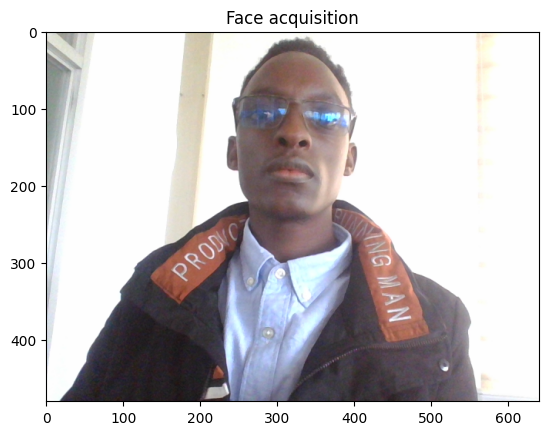

In [122]:
# tests the file-based face acquisition function
image_filepath = '/content/capture.png'
image = acquire_from_file(image_filepath, view=True)
assert image.size > 0

In [123]:
# Acquires an image that might contain a face from the webcam.
# The image is acquired with three color channels (BGR).
# Parameters
# image_filepath: The path to the image file that will store the captured PNG
# view: TRUE if captured image must be shown, FALSE otherwise.
def acquire_from_cam(image_filepath='/content/capture.png', view=False):
  # webcam capture
  _capture_png(image_filepath)

  # acquisition from file
  return acquire_from_file(image_filepath, view=view)

<IPython.core.display.Javascript object>

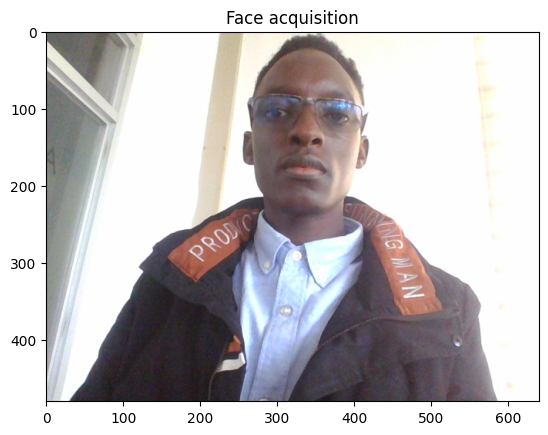

In [124]:
# tests the webcam-based face acquisition function
image = acquire_from_cam(view=True)
assert image.size > 0

------
## Face enhancement

### Auxiliary function
* <code>_rotate_face</code>: to rotate the given face image keeping eyes at the same level.

In [125]:
# rotates the given <image> and reference face rectangle <face_rect> CCW,
# obeying the given <rad_angle>.
# returns the rotated image and new face rectangle (x, y, w, h).
def _rotate_face(image, face_rect, rad_angle):
    # rotation matrix
    sine = np.sin(rad_angle)
    cosine = np.cos(rad_angle)

    rot_mat = np.zeros((3, 3))
    rot_mat[0, 0] = cosine
    rot_mat[0, 1] = -sine
    rot_mat[1, 0] = sine
    rot_mat[1, 1] = cosine
    rot_mat[2, 2] = 1.0

    # rotates the image borders
    rot_border = np.array([(0, 0), (0, image.shape[0]), (image.shape[1], 0), (image.shape[1], image.shape[0])])
    rot_border = cv2.perspectiveTransform(np.float32([rot_border]), rot_mat)[0]
    rot_w = int(round(np.max(rot_border[:, 0]) - np.min(rot_border[:, 0])))
    rot_h = int(round(np.max(rot_border[:, 1]) - np.min(rot_border[:, 1])))

    # translation added to the rotation matrix to compensate for negative points
    rot_mat[0, 2] = rot_mat[0, 2] - np.min(rot_border[:, 0])
    rot_mat[1, 2] = rot_mat[1, 2] - np.min(rot_border[:, 1])

    # rotates the given image
    rot_image = cv2.warpPerspective(image, rot_mat, (rot_w, rot_h))

    # rotates the given face rectangle
    x, y, w, h = face_rect
    rot_face_rect = np.array([(x, y), (x + w, y), (x, y + h), (x + w, y + h)])
    rot_face_rect = cv2.perspectiveTransform(np.float32([rot_face_rect]), rot_mat)[0]

    # computes a new non-rotated face rectangle containing the rotated one
    new_face_rect = np.min(rot_face_rect[:, 0]), np.min(rot_face_rect[:, 1]), np.max(
        rot_face_rect[:, 0]), np.max(rot_face_rect[:, 1])

    new_face_rect = int(round(new_face_rect[0])), int(round(new_face_rect[1])), int(
        round(new_face_rect[2] - new_face_rect[0])), int(round(new_face_rect[3] - new_face_rect[1]))

    # returns the rotated image and new face rectangle
    return rot_image, new_face_rect

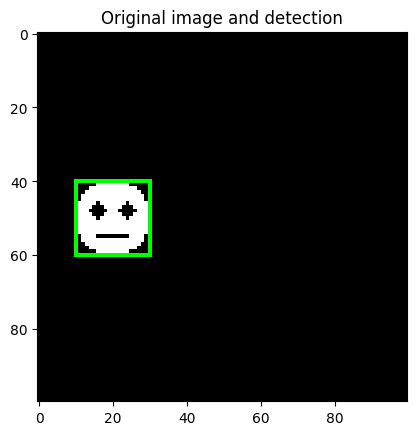

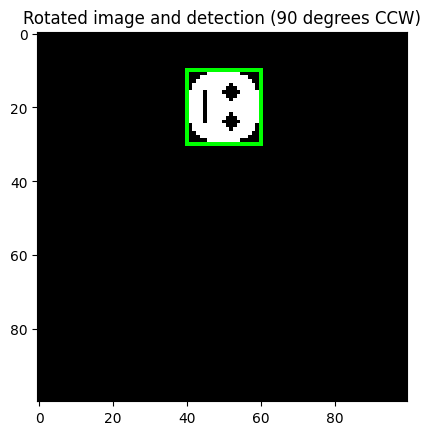

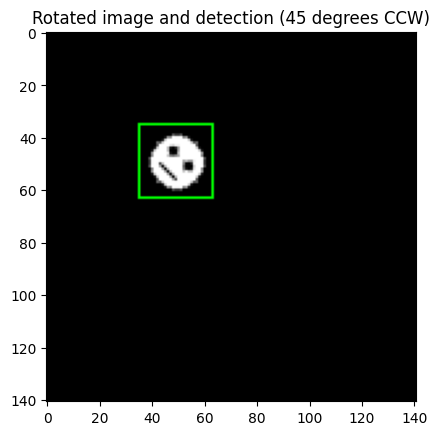

In [126]:
# tests the image rotation
# original toy-case image with synthetic face (white circle)
# and detection (green rectangle)
original_image = np.zeros((100, 100, 3), dtype=np.uint8)
cv2.circle(original_image, (20, 50), 10, (255, 255, 255), -1)
cv2.circle(original_image, (16, 48), 2, (0, 0, 0), -1)
cv2.circle(original_image, (24, 48), 2, (0, 0, 0), -1)
cv2.line(original_image, (16, 55), (24, 55), (0, 0, 0), 1)

face_rect = 10, 40, 20, 20
face_rect_p1 = face_rect[0:2]
face_rect_p2 = (face_rect[0] + face_rect[2], face_rect[1] + face_rect[3])

detection_image = original_image.copy()
cv2.rectangle(detection_image, face_rect_p1, face_rect_p2, (0, 255, 0), 1)

plt.pyplot.imshow(cv2.cvtColor(detection_image, cv2.COLOR_BGR2RGB))
plt.pyplot.title('Original image and detection')
plt.pyplot.show()

# rotates the image by 90 degrees CCW
rot_image, new_face_rect = _rotate_face(original_image, face_rect, np.pi / 2)
new_face_rect_p1 = new_face_rect[0:2]
new_face_rect_p2 = (new_face_rect[0] + new_face_rect[2],
                    new_face_rect[1] + new_face_rect[3])

detection_rot_image = rot_image.copy()
cv2.rectangle(detection_rot_image, new_face_rect_p1, new_face_rect_p2,(0, 255, 0), 1)

plt.pyplot.imshow(cv2.cvtColor(detection_rot_image, cv2.COLOR_BGR2RGB))
plt.pyplot.title('Rotated image and detection (90 degrees CCW)')
plt.pyplot.show()

# rotates the image by 45 degrees CCW
rot_image, new_face_rect = _rotate_face(original_image, face_rect, np.pi / 4)
new_face_rect_p1 = new_face_rect[0:2]
new_face_rect_p2 = (new_face_rect[0] + new_face_rect[2],
                    new_face_rect[1] + new_face_rect[3])

detection_rot_image = rot_image.copy()
cv2.rectangle(detection_rot_image, new_face_rect_p1, new_face_rect_p2,(0, 255, 0), 1)

plt.pyplot.imshow(cv2.cvtColor(detection_rot_image, cv2.COLOR_BGR2RGB))
plt.pyplot.title('Rotated image and detection (45 degrees CCW)')
plt.pyplot.show()

### Main steps
* <code>_01_preprocess</code>: to pre-process the given image, resizing and bringing it to grayscale.
* <code>_02_detect_face</code>: to detect a face on the given image.
* <code>_03_align_face</code>: to align the face so that both eyes are leveled.
* <code>_04_extract_face</code>: to crop and normalize the colors of the detected face.

In [128]:
# Preprocesses the given <image> for further face detection.
# Provide <view> as True if you want to see the result of computations.
# Returns the preprocessed image.
def _01_preprocess(image, image_width=640, view=False):
    # makes the image grayscale, if it is still colored
    if len(image.shape) > 2 and image.shape[2] > 1:  # more than one channel?
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # resizes the image to present a width of <image_width> pixels,
    # keeping the original aspect ratio
    aspect_ratio = float(image.shape[1]) / image.shape[0]
    height = int(round(image_width / aspect_ratio))
    image = cv2.resize(image, (image_width, height))

    # shows the obtained image, if it is the case
    if view:
      plt.pyplot.imshow(image, cmap='gray')
      plt.pyplot.title('Pre-processed image')
      plt.pyplot.show()

    return image

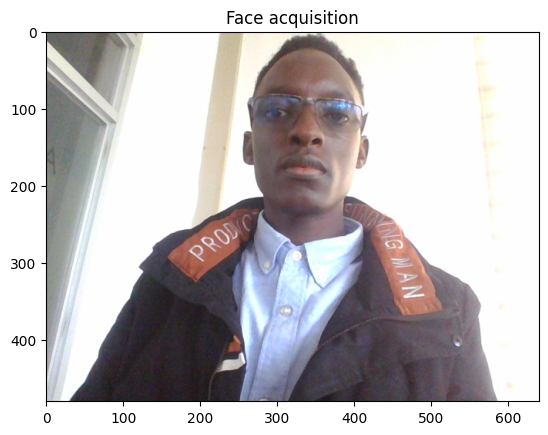

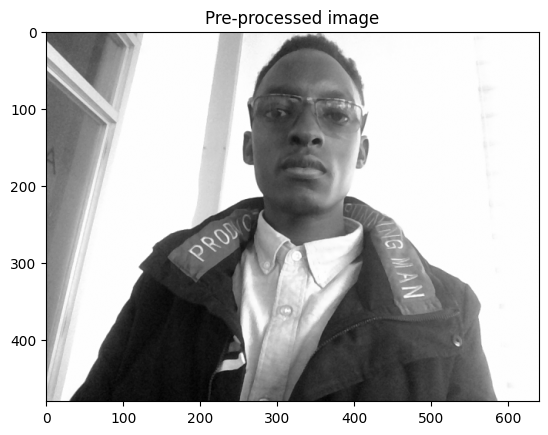

In [129]:
# tests the pre-processing of a given image
image = acquire_from_file('/content/capture.png', view=True)
pp_image = _01_preprocess(image, view=True)

In [130]:
# Detects the largest face over the given gray-scaled image.
# Provide <view> as True if you want to see the result of computations.
# Returns the rectangle (x, y, w, h) of the detected face.
def _02_detect_face(gs_image,
                    model_path='/content/violajones_haarcascade_frontalface_default.xml',
                    view=False):
    # detects faces on the given image with the Viola-Jones detector
    vj_face_detector = cv2.CascadeClassifier(model_path)
    face_boxes = vj_face_detector.detectMultiScale(gs_image)

    # if there are no faces, returns None
    if len(face_boxes) == 0:
        return None

    # else...
    # takes the largest face among the detected ones
    # TODO detecting more faces can be added here
    x, y, w, h = 0, 0, 0, 0
    size = 0
    for face in face_boxes:
        if face[2] * face[3] > size:
            x, y, w, h = face
            size = w * h

    # show the obtained face, if it is the case
    if view:
        view_image = cv2.cvtColor(gs_image, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(view_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        plt.pyplot.imshow(cv2.cvtColor(view_image, cv2.COLOR_BGR2RGB))
        plt.pyplot.title('Detected face')
        plt.pyplot.show()

    return x, y, w, h

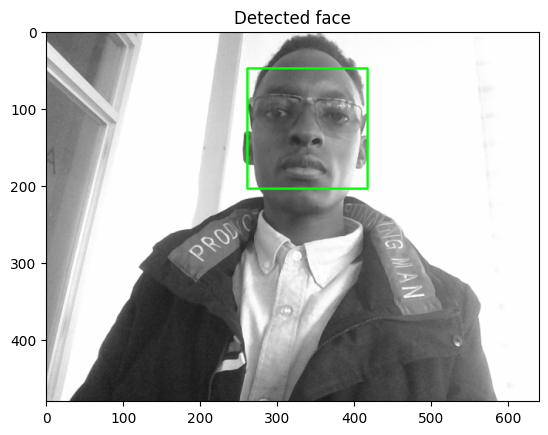

Detected face: (np.int32(261), np.int32(48), np.int32(156), np.int32(156))


In [131]:
# detecs a face on the given image
face = _02_detect_face(pp_image, view=True)
print('Detected face:', face)

In [132]:
# Transforms the given gray-scaled image <gs_image> according to the given
# face position <face_rect>, making it up-face aligned with the horizontal line.
# Provide <view> as True if you want to see the result of computations.
# Returns the transformed image and new rectangle (x, y, w, h)
# of the aligned face.
def _03_align_face(gs_image, face_rect,
                   model_path='/content/violajones_haarcascade_eye.xml',
                   view=False):
    # focus on the image region containing the face
    x, y, w, h = face_rect
    face_image = gs_image[y:y + h, x:x + w]

    # detects eyes on the face with Viola-Jones detector
    vj_eyes_detector = cv2.CascadeClassifier(model_path)
    eye_boxes = vj_eyes_detector.detectMultiScale(face_image)

    # if eyes were detected...
    if len(eye_boxes) == 2:
        # rotates the face in a way that eyes are aligned
        # in the horizontal position
        x1, y1, w1, h1, = eye_boxes[0]  # eye 1
        x2, y2, w2, h2, = eye_boxes[1]  # eye 2

        if x1 < x2:
            xc1 = x1 + w1 / 2.0  # right eye, mirrored on the left
            yc1 = y1 + h1 / 2.0

            xc2 = x2 + w2 / 2.0  # left eye, mirrored on the right
            yc2 = y2 + h2 / 2.0

        else:
            xc2 = x1 + w1 / 2.0  # left eye, mirrored on the right
            yc2 = y1 + h1 / 2.0

            xc1 = x2 + w2 / 2.0  # right eye, mirrored on the right
            yc1 = y2 + h2 / 2.0

        # angle between eyes
        angle = np.arctan2(yc2 - yc1, xc2 - xc1)

        # obtains the aligned image and new face rectangle
        gs_image, face_rect = _rotate_face(gs_image, face_rect, -angle)

    # shows the aligned face, if it is the case
    if view:
        x, y, w, h = face_rect
        view_image = cv2.cvtColor(gs_image, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(view_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        plt.pyplot.imshow(cv2.cvtColor(view_image, cv2.COLOR_BGR2RGB))
        plt.pyplot.title('Aligned face')
        plt.pyplot.show()

    return gs_image, face_rect

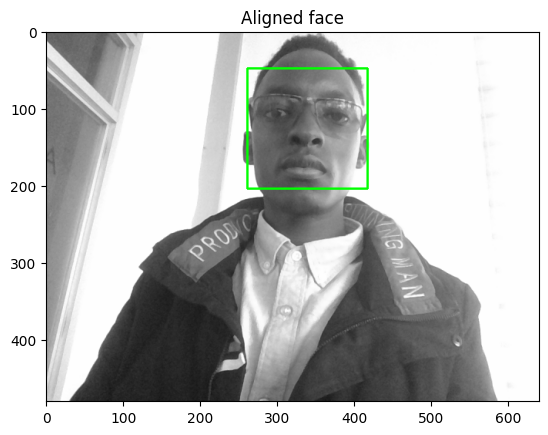

Aligned face: (np.int32(261), np.int32(48), np.int32(156), np.int32(156))


In [133]:
# aligns the detected face
al_image, al_face = _03_align_face(pp_image, face, view=True)
print('Aligned face:', al_face)

In [134]:
# Crops and normalizes the face contained in the given gray-scaled image
# <gs_image>, following the provided face rectangle <face_rect>.
# Provide <view> as True if you want to see the result of computations.
# Returns the extracted face, ready for description (feature extraction).
def _04_extract_face(gs_image, face_rect, face_size=256, view=False):
    x, y, w, h = face_rect
    cx = int(round(x + w / 2.0))
    cy = int(round(y + h / 2.0))
    r = int(round(max(w, h) / 2.0))

    face_image = gs_image[
                 max(0, cy - r):min(cy + r + 1, gs_image.shape[0]),
                 max(0, cx - r):min(cx + r + 1, gs_image.shape[1])]  # squared face
    if len(face_image) > 0:
        face_image = cv2.resize(face_image, (face_size, face_size))  # face in normalized size
        face_image = cv2.equalizeHist(face_image)  # color histogram normalization
    else:
        return None

    if view:
      plt.pyplot.imshow(face_image, cmap='gray')
      plt.pyplot.title('Extracted face')
      plt.pyplot.show()

    return face_image

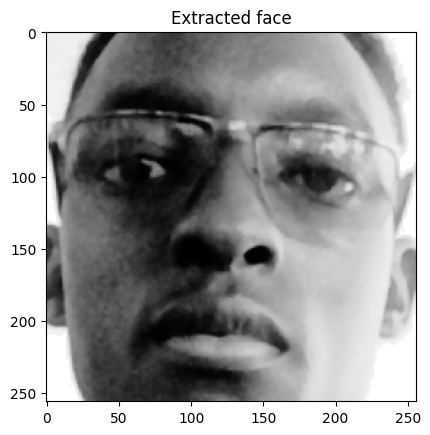

In [135]:
# tests the extraction of face
face_image = _04_extract_face(al_image, al_face, view=True)

### Main function

In [136]:
# Enhances the given image, returning the normalized version of the largest
# face depicted within it.
# Provide <view> as True if you want to see the results of computations.
# Returns the normalized face image, useful for description (feature extraction)
# or None, if no face was detected.
def enhance(image, view=False):
    # pre-processes the given image
    pp_image = _01_preprocess(image, view=view)

    # detects a face in the given image
    face_rect = _02_detect_face(pp_image, view=view)

    if face_rect is not None:
        # aligns the obtained face
        aligned_image, aligned_face = _03_align_face(pp_image, face_rect, view=view)

        # extracts and returns the detected face
        return _04_extract_face(aligned_image, aligned_face, view=view)

    # no face was found
    return None

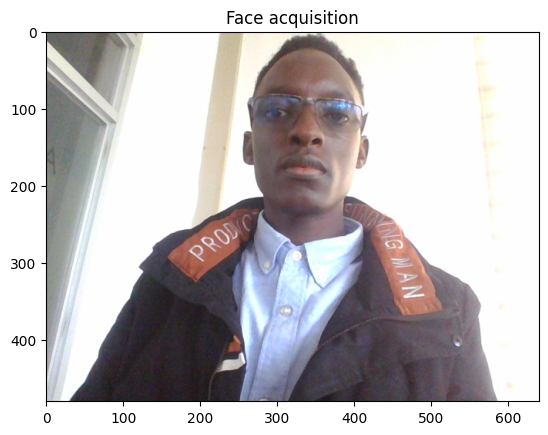

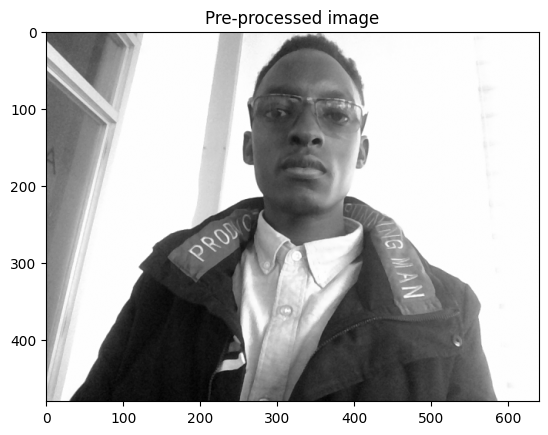

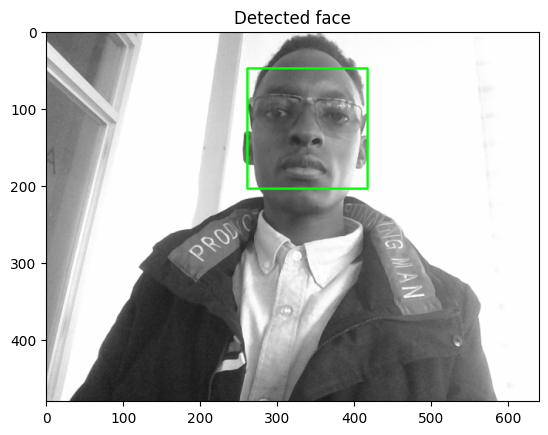

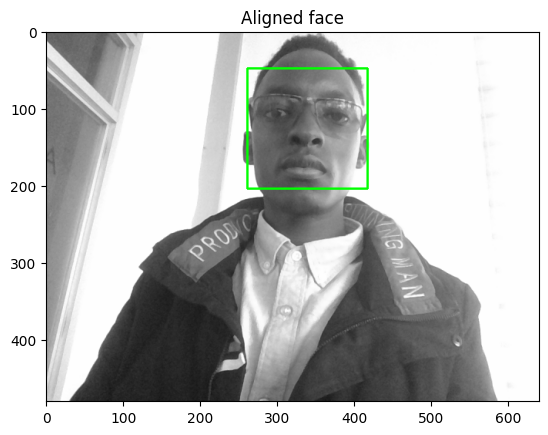

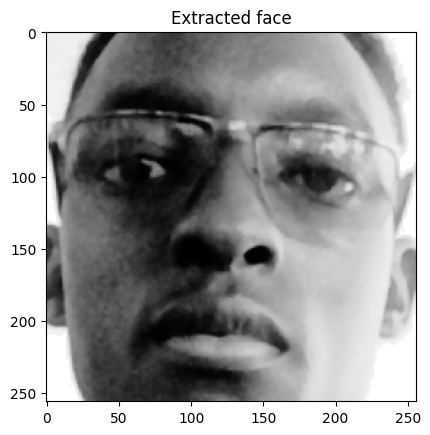

In [137]:
# tests the enhancement function
image = acquire_from_file('/content/capture.png', view=True)
face_image = enhance(image, view=True)

-------------------
## Face description

### Main function

In [139]:
from arcface import ArcFace

# Describes the given normalized face image <norm_face> with ArcFace.
# Returns the obtained feature vector.
def describe(norm_face, arc_face_model='/content/model.tflite'):
    face_descriptor = ArcFace.ArcFace(model_path=arc_face_model)
    feature_vector = face_descriptor.calc_emb(norm_face)
    return feature_vector

In [140]:
# tests the face description
description = describe(face_image)
print('Feature vector size:', description.shape)
print('Feature vector:', description)

Feature vector size: (512,)
Feature vector: [-5.39406985e-02 -2.12401338e-02 -7.98956156e-02  2.69850604e-02
 -4.86406591e-03 -3.23106796e-02  5.11857262e-03 -6.11475334e-02
 -5.21936119e-02  2.88729612e-02  1.02482429e-02 -8.20081402e-03
  6.50686398e-02 -3.13912481e-02 -3.14977653e-02 -7.78713301e-02
 -3.43731791e-02 -6.88511357e-02 -2.12126710e-02  3.52084860e-02
 -9.56394989e-03 -1.17662717e-02  1.16071841e-02  1.04870833e-02
  1.16965346e-01 -5.68453148e-02  1.85009893e-02 -3.21931727e-02
  1.42588196e-02 -4.91879210e-02  6.78991899e-03 -6.19904213e-02
  1.36384531e-03 -2.53206497e-04 -6.64133299e-03  8.69527608e-02
  4.85363416e-03 -3.89098004e-02  7.56624714e-02  9.53500122e-02
 -1.85840949e-02  5.76247051e-02 -5.43564633e-02  1.35229286e-02
  2.03781370e-02  7.77218200e-04  2.37732772e-02  1.73145235e-02
 -7.88941700e-03  2.84108911e-02  3.03767007e-02  1.23670436e-02
 -2.43472084e-02  8.30258727e-02  1.71499625e-02  1.21644087e-01
 -1.05289675e-01 -5.88779524e-02  8.94904882e-

--------------
## Face matching

### Main function

In [141]:
from arcface import ArcFace

# Matches the given feature vectors <description_1> and <description_2>.
# Returns the distance between them, expressing how likely they are of
# representing the same face.
# The distance is a positive real number.
def match(description_1, description_2, arc_face_model='/content/model.tflite'):
    face_descriptor = ArcFace.ArcFace(model_path=arc_face_model)
    distance = face_descriptor.get_distance_embeddings(description_1,
                                                       description_2)
    return distance

In [142]:
# tests the matching function
# same face compared to itself (same capture)
dist = match(description, description)
print('Distance:' , dist)
assert dist == 0


Distance: 0.0


<IPython.core.display.Javascript object>

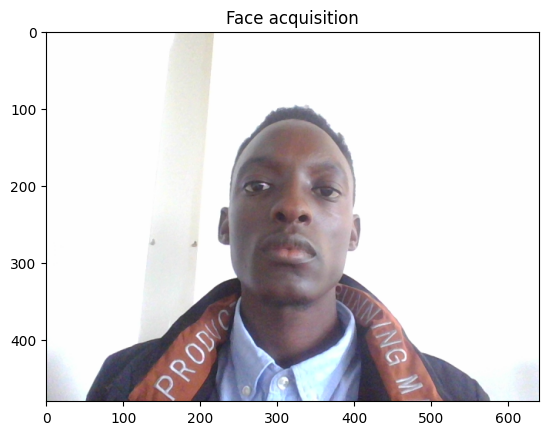

<IPython.core.display.Javascript object>

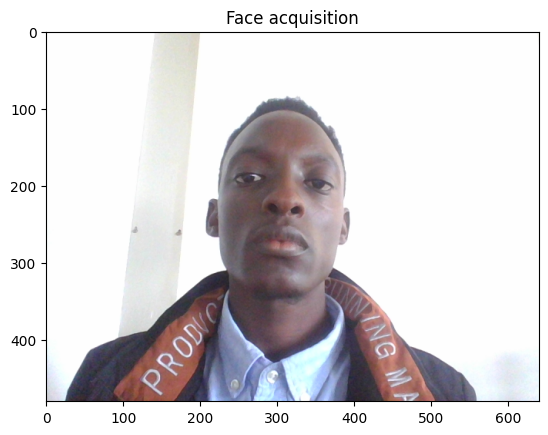

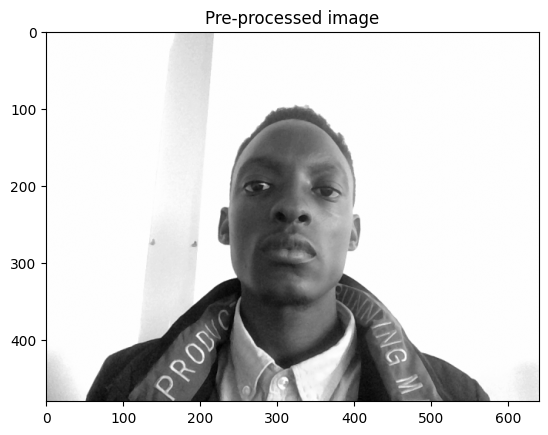

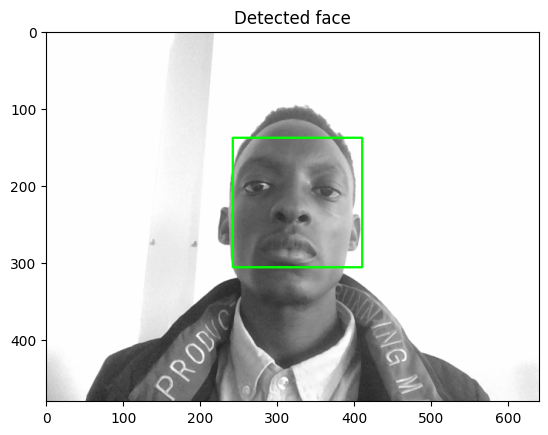

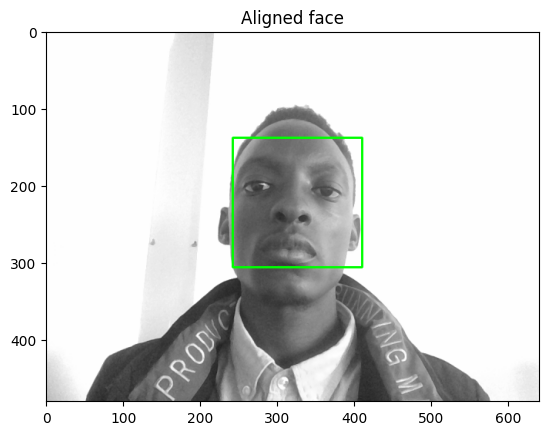

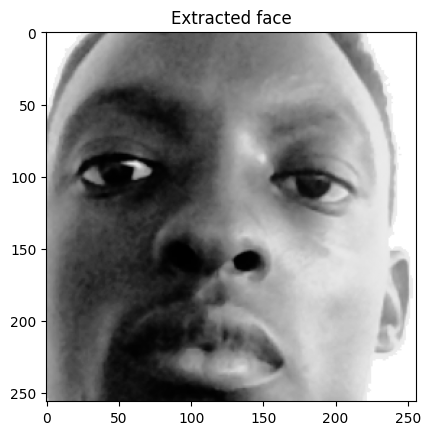

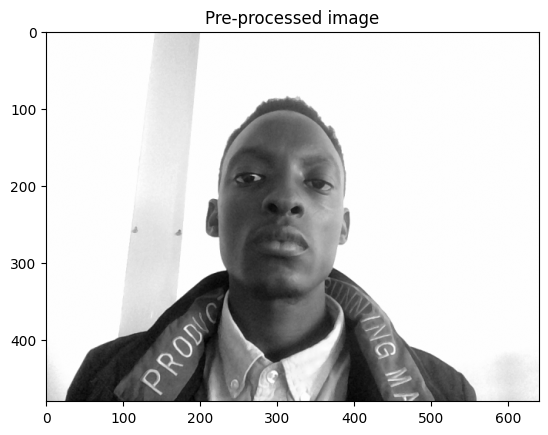

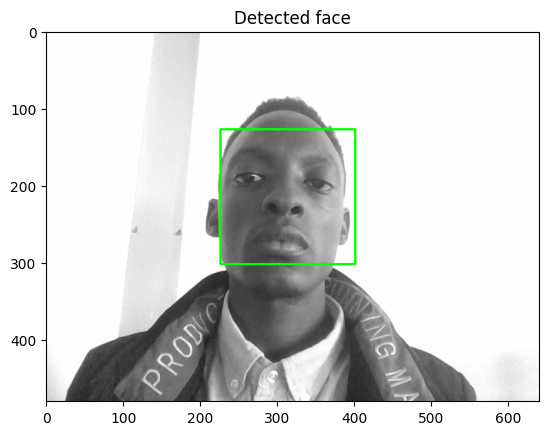

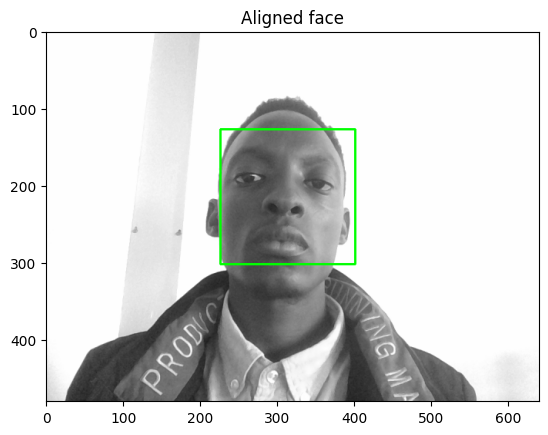

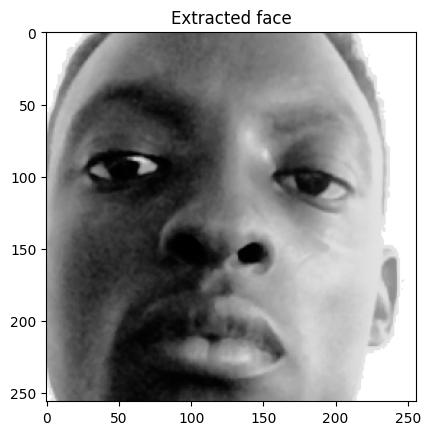

Distance: 0.0900127


In [148]:
# dynamicaly acquired faces
image_1 = acquire_from_cam(view=True)
image_2 = acquire_from_cam(view=True)

face_1 = enhance(image_1, view=True)
face_2 = enhance(image_2, view=True)

if face_1 is None:
    print('No face detected in image_1. Please try again.')
elif face_2 is None:
    print('No face detected in image_2. Please try again.')
else:
    description_1 = describe(face_1)
    description_2 = describe(face_2)
    dist = match(description_1, description_2)
    print('Distance:' , dist)


________
## Exercise

Download the 16 images with faces below and study their distances according to ArcFace's description.

In [150]:
# download of 16 images
!gdown 1Y5rQb6HGgpxlnj6LNo6u_lUctr6dgGwA
!gdown 1yVBf2s779yAS5cm22AC6IJ1fnU-zsMOZ
!gdown 1UQJqcgJKYLKJWCfi6gFae_4npa95M-LS
!gdown 1cAi4lCnsuXM2Lcd7gbhJZx_GoFusfN1i
!gdown 1FizW_0tCc5ysbJyPr3_hXCZZOTxvXi3O
!gdown 1a4pWT7423G3HLt8mDUtr79nYjR9EBOWO
!gdown 1Zw2SGR8li3k7Oi3PPlAlUvUaRNLlQ2dc
!gdown 1ULuUlNIdnN7hkSSJti7psFYH65VQVDGt
!gdown 1hO82av0RUJO1ECK2scm6miAETjCg-OIs
!gdown 1_Aca0L5QcioA6Uivss7KOHivQLN7uN_z
!gdown 1VtFelqyqYSLl4MBIOj5c2ov00Auesjai
!gdown 1sCxXJqtEu3SOtxX4JiPxvp4bYQ4Ppt6G
!gdown 1nBLwFuUf8GHm5cgHojtCKjrBcKH4BDgR
!gdown 12MI79nkO8IZfP9uW8pNsNgRkz4gEV19_
!gdown 1HRZX8BaAimfZj0NV2bfR8FoSuddJQOZn
!gdown 1XrqSXNKCPyruyhIGWvnHbZlhIik0okkC

Downloading...
From: https://drive.google.com/uc?id=1Y5rQb6HGgpxlnj6LNo6u_lUctr6dgGwA
To: /content/0101.jpg
100% 97.5k/97.5k [00:00<00:00, 78.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yVBf2s779yAS5cm22AC6IJ1fnU-zsMOZ
To: /content/0102.jpg
100% 63.2k/63.2k [00:00<00:00, 73.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UQJqcgJKYLKJWCfi6gFae_4npa95M-LS
To: /content/0201.jpg
100% 235k/235k [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cAi4lCnsuXM2Lcd7gbhJZx_GoFusfN1i
To: /content/0202.jpg
100% 105k/105k [00:00<00:00, 65.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FizW_0tCc5ysbJyPr3_hXCZZOTxvXi3O
To: /content/0301.jpg
100% 57.1k/57.1k [00:00<00:00, 66.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a4pWT7423G3HLt8mDUtr79nYjR9EBOWO
To: /content/0302.jpg
100% 38.0k/38.0k [00:00<00:00, 71.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Zw2SGR8li3k7Oi3PPlAlUvUaRNLlQ2dc
To: /content/0401.jpg
100

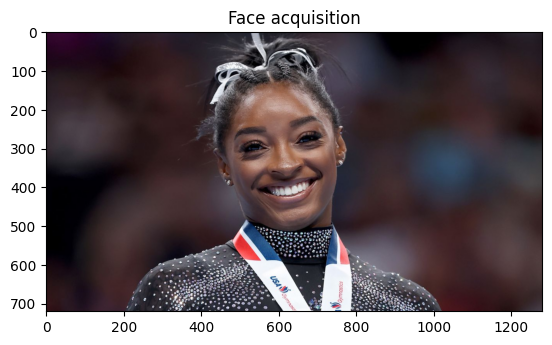

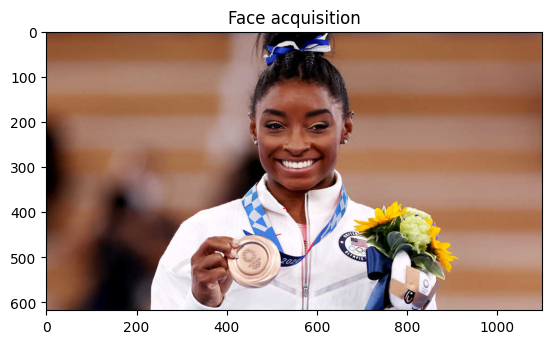

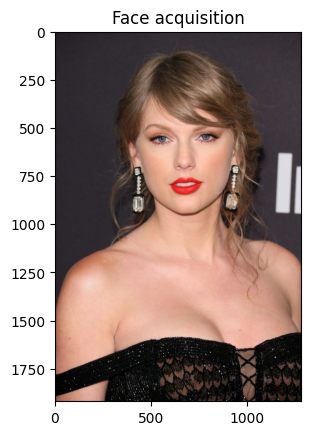

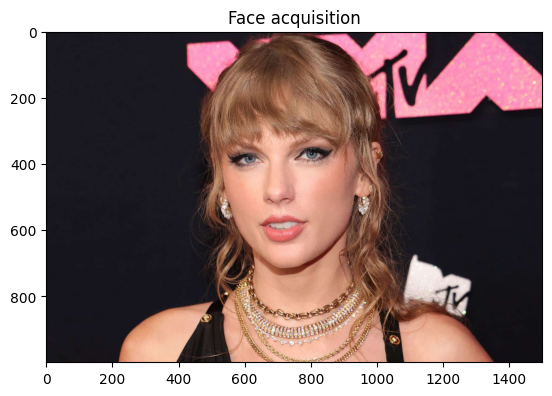

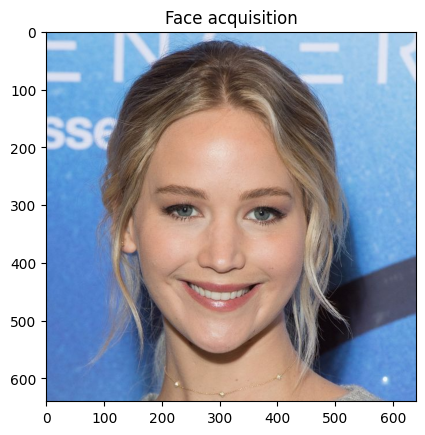

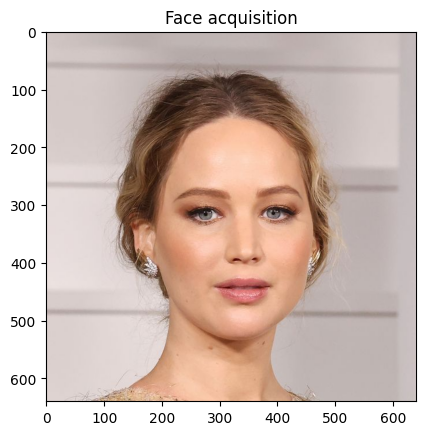

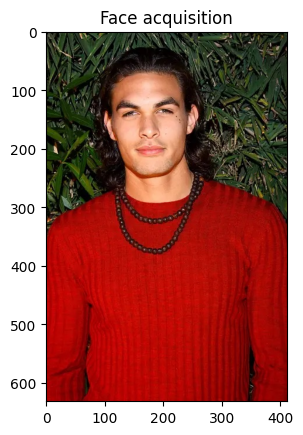

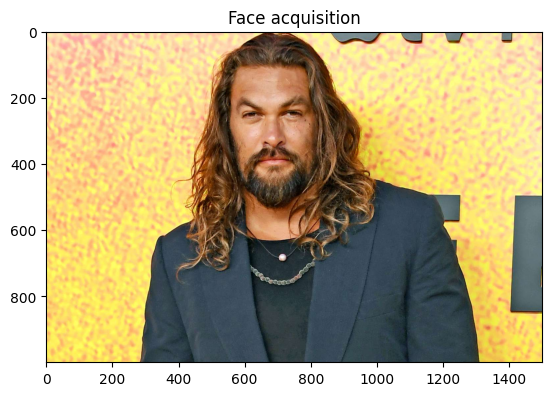

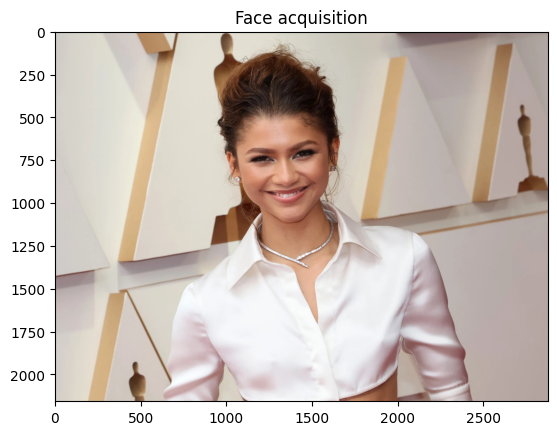

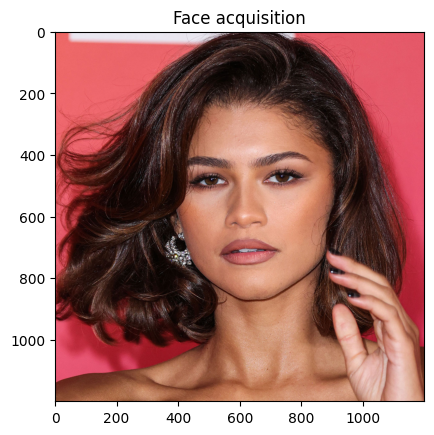

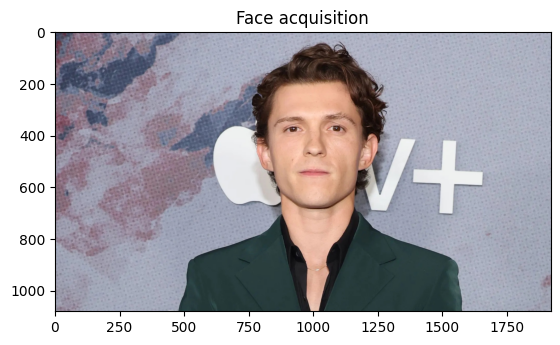

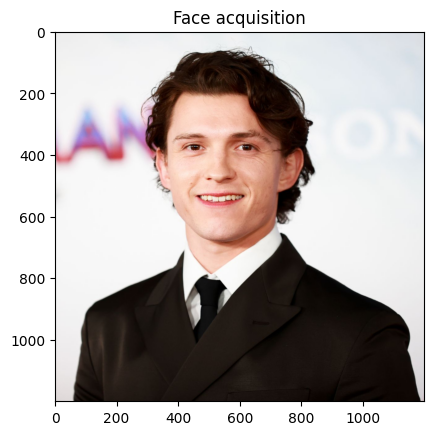

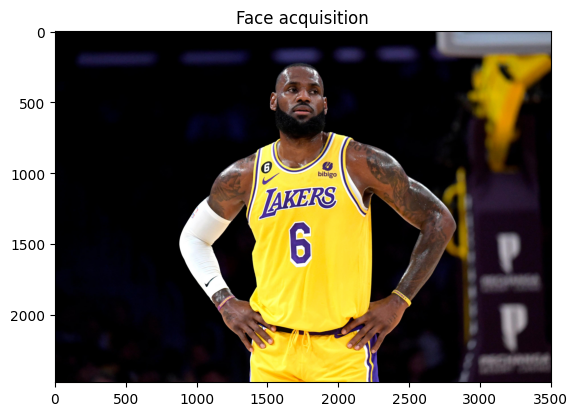

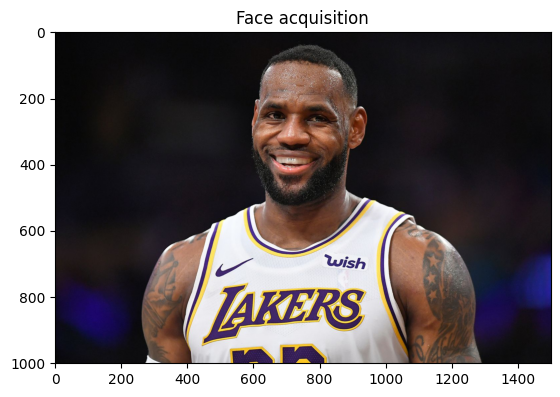

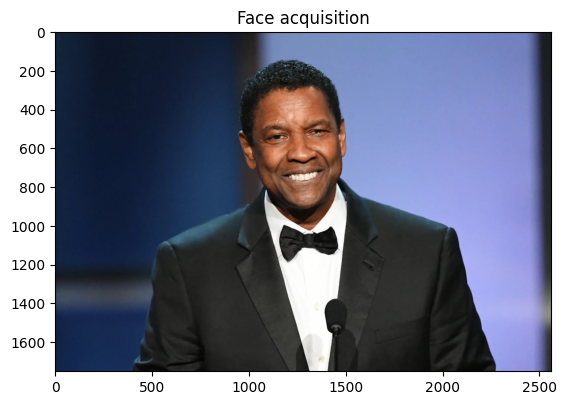

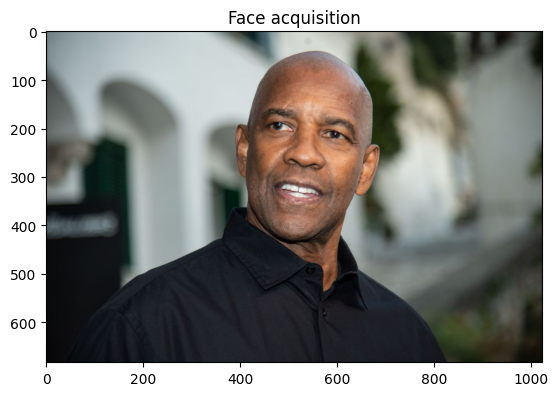

In [151]:
# obtained faces
image_0101 = acquire_from_file('/content/0101.jpg', view=True)
image_0102 = acquire_from_file('/content/0102.jpg', view=True)
image_0201 = acquire_from_file('/content/0201.jpg', view=True)
image_0202 = acquire_from_file('/content/0202.jpg', view=True)
image_0301 = acquire_from_file('/content/0301.jpg', view=True)
image_0302 = acquire_from_file('/content/0302.jpg', view=True)
image_0401 = acquire_from_file('/content/0401.jpg', view=True)
image_0402 = acquire_from_file('/content/0402.jpg', view=True)
image_0501 = acquire_from_file('/content/0501.jpg', view=True)
image_0502 = acquire_from_file('/content/0502.jpg', view=True)
image_0601 = acquire_from_file('/content/0601.jpg', view=True)
image_0602 = acquire_from_file('/content/0602.jpg', view=True)
image_0701 = acquire_from_file('/content/0701.jpg', view=True)
image_0702 = acquire_from_file('/content/0702.jpg', view=True)
image_0801 = acquire_from_file('/content/0801.jpg', view=True)
image_0802 = acquire_from_file('/content/0802.jpg', view=True)

In [ ]:
# add your study here
